In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# enter the directory 
%cd /content/gdrive/MyDrive/1_Udacity/3_RNN

In [ ]:
# Load packages
import gensim
import nltk
import numpy as np
import pandas as pd
import gzip
import torch
from nltk.corpus import brown
from torchtext.datasets import SQuAD1
import string
import pickle 
import torch.nn as nn
import random 
from sklearn.model_selection import train_test_split

In [ ]:
# Installing and loading additional packages
# Restart after run
!pip install livelossplot
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# loading stemmer and creating tokenizer
stemmer = nltk.stem.snowball.SnowballStemmer('english')
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
# Load Squad1 training data data obtailed using 'Data_table_prep.ipynb' - that notebook was run on local computer
train_data = pd.read_csv('train_data_sq1.csv')

In [ ]:
# create vocabulary objects
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Vocab:
    def __init__(self, name):
        self.name = name
        self.words2index = {}
        self.word_number = 3
        self.index2word = {PAD_token: "<PAD>", SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.word2count = {}
        
    def cleanText(self, text):
        tokenizer = RegexpTokenizer(r'\w+')
        text = tokenizer.tokenize(text)
        return text

    def indexWord(self, word):
        word = word.lower()
        if word not in self.words2index:
            self.words2index[word] = self.word_number
            self.index2word[self.word_number] = word
            self.word2count[word] = 1
            self.word_number +=1
        else:
            self.word2count[word] += 1

    def trim(self, min_count_allowed):

        td = self.word2count
        trimmed_words = pd.DataFrame([td]).T
        trimmed_words.rename(columns={ trimmed_words.columns[0]: "counts" }, inplace = True)
        trimmed_words['words'] = trimmed_words.index
        trimmed_words = trimmed_words[trimmed_words["counts"]>=min_count_allowed]

        trimmed_words = trimmed_words['words'].tolist()
        # Reinitialize dictionaries
        self.words2index = {}
        self.word_number = 3
        self.index2word = {PAD_token: "<PAD>", SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.word2count = {}

        for word in trimmed_words:
            self.indexWord(word)

In [ ]:
# remove missing data
train_data_qa = train_data[train_data['Answer'].notna()]
train_data_qa = train_data_qa.reset_index(0)


In [ ]:
# further data preprocessing

# function from https://github.com/iJoud/Seq2Seq-Chatbot/blob/main/src/Data.py
def prepare_text(sentence):
    # clean text and tokenize it 
    sentence = ''.join([s.lower() for s in sentence if s not in string.punctuation])
    sentence = ' '.join(stemmer.stem(w) for w in sentence.split())
    tokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sentence)
    return tokens


train_data_qa['q_tokens'] = ''
train_data_qa['q_tokens'].astype(object)
train_data_qa['a_tokens'] = ''
train_data_qa['a_tokens'].astype(object)


for i in range(0, train_data_qa.shape[0]):
    #print(i)
    # i=0    
    train_data_qa.at[i,'q_tokens'] = prepare_text(train_data_qa.loc[i,'Question'])
    train_data_qa.at[i,'a_tokens'] = prepare_text(train_data_qa.loc[i,'Answer'])



# creating disctionaries
miss = 0
SRC = Vocab('squad_q')
for i in range(0, train_data_qa.shape[0]): 
 
    if type(train_data_qa.loc[i, 'Question']) == str:
        for j in train_data_qa.loc[i, 'q_tokens']:
            SRC.indexWord(j)
    else: 
        miss+=1
        next

miss = 0
TRG = Vocab('squad_a')
for i in range(0, train_data_qa.shape[0]):
    if type(train_data_qa.loc[i, 'Answer']) == str:
        for j in train_data_qa.loc[i, 'a_tokens']:
            TRG.indexWord(j)
    else: 
        miss+=1
        next

# trimming disctionaries
SRC.trim(2)
TRG.trim(2)

In [ ]:
# remove the  Q&A pairs which contain words trimmed from any of 2 vocabularies
train_data_qa['keep'] = True
# Remove Q&A if they contain rare words
for i in range(0, train_data_qa.shape[0]): 
    # i = 0
    #print(i)
    list_temp = train_data_qa.loc[i, 'q_tokens'] + train_data_qa.loc[i, 'a_tokens']
    for j in list_temp:
        j = j.lower()
        if ( (j not in SRC.words2index) | (j not in TRG.words2index) ):
            train_data_qa.loc[i,'keep'] = False

train_data_qa_trim = train_data_qa[train_data_qa['keep']==True]

In [ ]:
print( SRC.word_number )
print( TRG.word_number )

15670
15504


In [ ]:
# function to convert words to indexes
def conv2index(input_list, vocab):
    indices = [vocab.words2index[word] for word in input_list]
    indices = [1] + indices + [2] 
    return indices

In [ ]:
# removing NA
train_data_qa_trim = train_data_qa_trim[train_data_qa_trim['Answer'].notna()]

# adding columns with lists of indexes
source_data = []
target_data = []
for i in range(0, train_data_qa_trim.shape[0]):
    #print(i)
    source_data.append(  conv2index(train_data_qa_trim.iloc[i,3], SRC)  )
    target_data.append(  conv2index(train_data_qa_trim.iloc[i,4], TRG)  )
    
train_data_qa_trim['Q_indexes'] = source_data  
train_data_qa_trim['A_indexes'] = target_data 

In [ ]:
train_data_qa_trim.head(5)

,index,Question,Answer,q_tokens,a_tokens,keep,Q_indexes,A_indexes
1,1,What is in front of the Notre Dame Main Building?,a copper statue of Christ,"[what, is, in, front, of, the, notr, dame, mai...","[a, copper, statu, of, christ]",True,"[1, 15, 16, 11, 17, 18, 6, 19, 20, 21, 22, 2]","[1, 4, 5, 6, 7, 8, 2]"
2,2,The Basilica of the Sacred heart at Notre Dame...,the Main Building,"[the, basilica, of, the, sacr, heart, at, notr...","[the, main, build]",True,"[1, 6, 23, 18, 6, 24, 25, 26, 19, 20, 16, 27, ...","[1, 9, 10, 11, 2]"
4,4,What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,"[what, sit, on, top, of, the, main, build, at,...","[a, golden, statu, of, the, virgin, mari]",True,"[1, 15, 31, 32, 33, 18, 6, 21, 22, 26, 19, 20, 2]","[1, 4, 17, 6, 7, 9, 18, 19, 2]"
5,5,When did the Scholastic Magazine of Notre dame...,September 1876,"[when, did, the, scholast, magazin, of, notr, ...","[septemb, 1876]",True,"[1, 34, 5, 6, 35, 36, 18, 19, 20, 37, 38, 2]","[1, 20, 21, 2]"
7,7,What is the daily student paper at Notre Dame ...,The Observer,"[what, is, the, daili, student, paper, at, not...","[the, observ]",True,"[1, 15, 16, 6, 41, 42, 43, 26, 19, 20, 44, 2]","[1, 9, 23, 2]"


In [ ]:
# defining the device
device = 'cuda'
#device = 'cpu'

# creating tensors using the defined device
source_data = []
target_data = []
for i in range(0,train_data_qa_trim.shape[0]):
    source_data.append(torch.Tensor(train_data_qa_trim.iloc[i,6]).long().to(device))
    target_data.append(torch.Tensor(train_data_qa_trim.iloc[i,7]).long().to(device))

print( source_data[0].cpu().numpy() ) 
print( target_data[0].cpu().numpy() ) 

[ 1 15 16 11 17 18  6 19 20 21 22  2]
[1 4 5 6 7 8 2]


In [ ]:
# limiting the data to the first 6000 Q&A pairs to accelerate the training
source_data = source_data[0:6000]
target_data = target_data[0:6000]
len(source_data)

6000

In [ ]:
# checking the data
target_data[1]

tensor([ 1,  9, 10, 11,  2])

In [ ]:
#pickle.dump( source_data, open( "source_data230305_6000.p", "wb" ) ) 
#pickle.dump( target_data, open( "target_data230305_6000.p", "wb" ) ) 
source_data = pickle.load( open( "source_data230305_6000.p", "rb" ) ) 
target_data = pickle.load( open( "target_data230305_6000.p", "rb" ) ) 
print( source_data[0].cpu().numpy() ) 
print( target_data[0].cpu().numpy() ) 

[ 1 15 16 11 17 18  6 19 20 21 22  2]
[1 4 5 6 7 8 2]


# Create Seq2Seq model

In [ ]:
# Defining the Encoder, Decoder and Seq2Seq

# based on the model from  https://github.com/iJoud/Seq2Seq-Chatbot/blob/main/src/Models.py
class Encoder(nn.Module):
  
    def __init__(self, input_size, emb_size, hidden_size, n_layers, dropout):
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.emb_size = emb_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(self.input_size, self.emb_size)
        # self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.rnn = nn.LSTM(emb_size, hidden_size, n_layers, dropout = dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell_state):
        
        x = self.dropout( self.embedding(x).view(1, 1, -1) )
        x, (hidden, cell_state) = self.rnn(x, (hidden, cell_state))
        
        return x, hidden, cell_state
        

class Decoder(nn.Module):

    def __init__(self, output_size, emb_size, hidden_size, n_layers, dropout):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.emb_size = emb_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout)

        self.embedding = nn.Embedding(self.output_size, self.emb_size)

        self.rnn = nn.LSTM(emb_size, hidden_size, n_layers, dropout = dropout)
        # self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, cell_state):
        
        x = self.dropout( self.embedding(x).view(1, 1, -1) )
        x, (hidden, cell_state) = self.rnn(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        
        return x, hidden, cell_state
    
     
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, emb_size, n_layers, dropout):
        super(Seq2Seq, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.emb_size = emb_size
        self.n_layers = n_layers

        self.encoder = Encoder(self.input_size, self.emb_size, self.hidden_size, self.n_layers, dropout)
        self.decoder = Decoder(self.output_size, self.emb_size, self.hidden_size, self.n_layers, dropout)
        
    def forward(self, src, trg, teacher_force, training ):
        
        output = []
       
        encoder_hidden = torch.ones([n_layers, 1, hidden_size]).to(device) 
        cell_state = torch.ones([n_layers, 1, hidden_size]).to(device)  

        for i in range(src.size()[0]):
            encoder_output, encoder_hidden, cell_state = self.encoder(src[i], encoder_hidden, cell_state)

        decoder_input = torch.Tensor([[1]]).long().to(device) 
        decoder_hidden = encoder_hidden
        
        for i in range(trg.size()[0]): 
            decoder_output, decoder_hidden, cell_state = self.decoder(decoder_input, decoder_hidden, cell_state)
            output.append(torch.squeeze(decoder_output) )     
            if training:
                if random.random() < teacher_force:
                    decoder_input = trg[i]
                else:
                    decoder_input = decoder_output.argmax(1) 
            else:
                decoder_input = torch.argmax(decoder_output,1).view(1, 1) 
                        
        return output

# Train

In [ ]:
# Defining the training loop

# based on https://github.com/iJoud/Seq2Seq-Chatbot/blob/main/src/Train.py
def train_one_epoch(model, source_data, target_data, batch_size, optimizer, criterion, eploch_random_state):
    
    model.to(device)
    total_training_loss = 0
    total_valid_loss = 0
    batch_loss = 0
 

    X_train, X_test, y_train, y_test = train_test_split(source_data, target_data, test_size=0.166, random_state=eploch_random_state)


    # train loop
    model.train()
    for i in range(0, len(X_train)):
        src = X_train[i]
        trg = y_train[i]
        
        teacher_force = 0
        training = True
        out = model(src, trg, teacher_force, training)

        word_loss = 0
        for (s_char, t_char) in zip(out, trg): 
            word_loss += criterion(s_char, t_char)

        batch_loss += word_loss
        total_training_loss += (word_loss / trg.size(0))

        if i % batch_size == 0 or i == (len(X_train)-1):
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss = 0

    training_loss_average = total_training_loss / len(X_train)
    # validation loop
    model.eval()
    for i in range(0, len(X_test)):
        src = X_test[i]
        trg = y_test[i]

        teacher_force = 0
        training = False
        output = model(src, trg, teacher_force, training)

        word_loss = 0
        for (s_char, t_char) in zip(output, trg): 
            word_loss += criterion(s_char, t_char)

        total_valid_loss += (word_loss / trg.size(0))

    validation_loss_average = total_valid_loss / len(X_test)

    return training_loss_average, validation_loss_average
    



In [ ]:
import matplotlib.pyplot as plt
import time
import math

# Useful functions for monitoring the performance

# from Udacity solution for Improving performance (CNN in depth)
def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

    if group_name.lower() == "loss":
        ax.set_ylim([0, 10])

# from https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

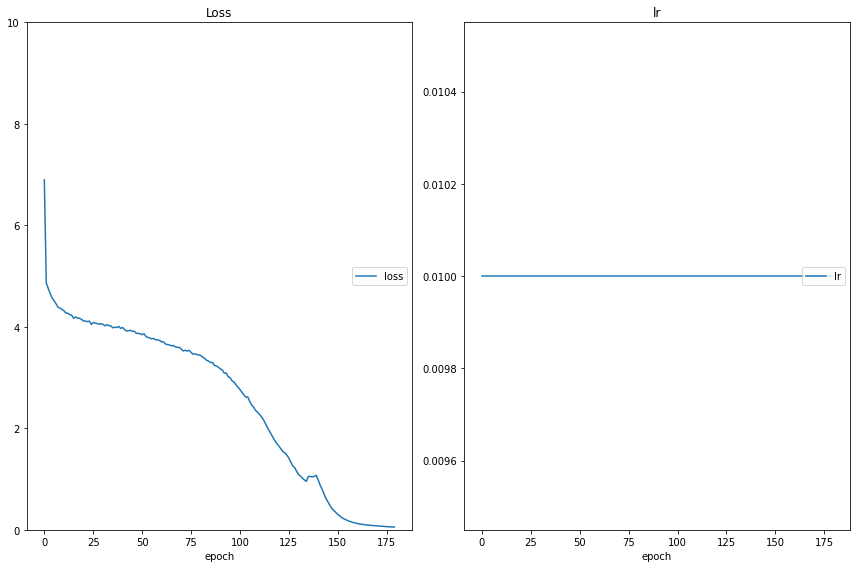

Epoch: 180 | Time: 1m 2s
	Train Loss: 0.056 


In [ ]:
# looping over based on optimise function from train.py in Landmark classification project

# setting the device
device = 'cuda'

# setting hyperparameters
learning_rate = 0.01

input_size = SRC.word_number
hidden_size = 128
output_size = TRG.word_number

emb_size = 128
n_layers = 2
dropout = 0

batch_size = 128

epochs = 180

# initiating the model, optimiser and loss function
model = Seq2Seq(SRC.word_number , hidden_size, TRG.word_number, emb_size, n_layers, dropout)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# looping through the eploches
best_train_loss = float('inf')

logs = {}
liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
epoch=0
for epoch_random_state in random.sample(range(100, 1000), epochs):
    start_time = time.time()
    train_avg_loss, valid_avg_loss = train_one_epoch(model, source_data, target_data, batch_size, optimizer, criterion, epoch_random_state)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if (train_avg_loss < best_train_loss) and (epoch%10==0):
        best_train_loss = train_avg_loss
        save_name = 'd1_weight'+str(epoch)+'.pt' 
        torch.save(model.state_dict(), save_name)

    logs["loss"] = float(train_avg_loss.detach().cpu().numpy())
    logs["lr"] = optimizer.param_groups[0]["lr"]

    liveloss.update(logs)
    liveloss.send()
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_avg_loss:.3f} ')
    epoch+=1

# Evaluate

In [ ]:
# defining the hyperparameters for the trained chatbot 
device = "cuda"
hidden_size = 128
emb_size = 128
n_layers = 2
dropout = 0

# loading the trained chatbot with weights
seq2seq = Seq2Seq(SRC.word_number , hidden_size, TRG.word_number, emb_size, n_layers, dropout)
seq2seq.load_state_dict(torch.load('d1_weight170.pt',map_location=device))
seq2seq.to(torch.device('cuda'))

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(15670, 128)
    (rnn): LSTM(128, 128, num_layers=2)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0, inplace=False)
    (embedding): Embedding(15504, 128)
    (rnn): LSTM(128, 128, num_layers=2)
    (fc): Linear(in_features=128, out_features=15504, bias=True)
    (softmax): LogSoftmax(dim=1)
  )
)

# ex, Question & Answer List

In [ ]:
train_data_qa_trim.head(3)

,index,Question,Answer,q_tokens,a_tokens,keep,Q_indexes,A_indexes
1,1,What is in front of the Notre Dame Main Building?,a copper statue of Christ,"[what, is, in, front, of, the, notr, dame, mai...","[a, copper, statu, of, christ]",True,"[1, 15, 16, 11, 17, 18, 6, 19, 20, 21, 22, 2]","[1, 4, 5, 6, 7, 8, 2]"
2,2,The Basilica of the Sacred heart at Notre Dame...,the Main Building,"[the, basilica, of, the, sacr, heart, at, notr...","[the, main, build]",True,"[1, 6, 23, 18, 6, 24, 25, 26, 19, 20, 16, 27, ...","[1, 9, 10, 11, 2]"
4,4,What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,"[what, sit, on, top, of, the, main, build, at,...","[a, golden, statu, of, the, virgin, mari]",True,"[1, 15, 31, 32, 33, 18, 6, 21, 22, 26, 19, 20, 2]","[1, 4, 17, 6, 7, 9, 18, 19, 2]"


In [ ]:
# functiojn to run the chatbot, give the input sentences and print the output

def chatbot(sentence, model, vocabulary):
    #sentence = train_data_qa_trim.iloc[n,1]
    sentence = ''.join([s.lower() for s in sentence if s not in string.punctuation])
    sentence = ' '.join(stemmer.stem(w) for w in sentence.split())
    tokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sentence)

    indices = [vocabulary.words2index[word] for word in tokens]
    indices = [1] + indices + [2] 
    # indices
    src = torch.Tensor(indices).long().to(device)
    # print(src)
    trg = torch.Tensor([0]*15).long().to(device)
    # print(trg)
    
    teacher_force = 0
    training = False
    outcome = model(src, trg,teacher_force, training)
    reply = []
    for i in range(trg.size()[0]):
      reply.append( TRG.index2word[int(torch.argmax(outcome[i],0).cpu().numpy())] )
    # print(reply)
    
    # get clean reply without <SOS> and <EOS>
    clean_reply = []
    reply = reply[1:]
    for i in reply:
      if i != '<EOS>':
        clean_reply.append(i)
      if i == '<EOS>': break
    clean_reply
    if len(clean_reply) == 0:
      clean_reply.append('THERE WERE NO PREDICTION')
    clean_reply_str = (" ".join(clean_reply))
    # print("------------------------")
    print("Output: ", clean_reply_str, "\n")
     

In [ ]:
# Running the chatbot
print("Enter your sentence",'\n')
print("Type 'exit' to exit from the chat.\n", '\n')

while (True):
    sentence = input("Input: ")
    if sentence.strip() == "exit":
        break
    chatbot(sentence, seq2seq, SRC)

Enter your sentence 

Type 'exit' to exit from the chat.
 

Input: How many student news papers are found at Notre Dame?
Output:  three 

Input: What is the oldest structure at Notre Dame?
Output:  old colleg 

Input: How many BS level degrees are offered in the College of Engineering at Notre Dame?
Output:  eight 

Input: What is the daily student paper at Notre Dame called?
Output:  the observ 

Input: The Basilica of the Sacred heart at Notre Dame is beside to which structure?
Output:  the the great 

Input: exit
